<a href="https://colab.research.google.com/github/mvivekc/sentinment_analysis/blob/master/Sentiment_Analysis_with_PySpark_working_with_graphs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis with Pyspark

This project is inspired from a medium article [sentiment-analysis-with-pyspark](https://towardsdatascience.com/sentiment-analysis-with-pyspark-bc8e83f80c35). 

Pandas and Scikit-Learn is enough to handle processing of small data but for big data (in the scale of petabytes), we need advanced tools such as Pyspark.


Pyspark can process data with distributed computing framework hence, you can efficiently implement the task for large data sets.

Spark API is available in multiple programming languages (Scala, Java, Python and R).

To use Pyspark in Jupyter Notebook, we use a package called Findspark to make a Spark Context available in your Jupyter Notebook. 

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://ftp.heanet.ie/mirrors/www.apache.org/dist/spark/spark-2.4.1/spark-2.4.1-bin-hadoop2.7.tgz
!tar xf spark-2.4.1-bin-hadoop2.7.tgz
!pip install -q findspark

Check if java is installed and also get the version of java currently running.

In [0]:
!java --version

openjdk 10.0.2 2018-07-17
OpenJDK Runtime Environment (build 10.0.2+13-Ubuntu-1ubuntu0.18.04.4)
OpenJDK 64-Bit Server VM (build 10.0.2+13-Ubuntu-1ubuntu0.18.04.4, mixed mode)


Lets set java runtime variables for hadoop installation to start using the correct java instance

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.0-bin-hadoop2.7"

Intitiating pyspark and finding the respective configuration using findspark

In [0]:
import findspark
findspark.init()
import pyspark as ps
import warnings
from pyspark.sql import SQLContext

IndexError: ignored

In [0]:
import numpy as np
import pandas as pd
from pandas import DataFrame
from pandas import Series

First step in any Apache programming is to create a SparkContext. SparkContext is needed when we want to execute operations in a cluster. SparkContext tells Spark how and where to access a cluster. It is first step to connect with Apache Cluster. 

In [0]:
try:
    # create SparkContext on all CPUs available: in my case I have 4 CPUs on my laptop
    sc = ps.SparkContext('local')
    sqlContext = SQLContext(sc)
    print("Just created a SparkContext")
except ValueError:
    warnings.warn("SparkContext already exists in this scope")

Just created a SparkContext


In [0]:
sc.master

u'local'

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!ls "/content/drive/My Drive/ml_learning/cloud"

testdata.manual.2009.06.14.csv	training.1600000.processed.noemoticon.csv


The dataset I'll use for this post is annotated Tweets from "Sentiment140". It originated from a Stanford research project, and I used this dataset for my previous series of Twitter sentiment analysis. Since I already cleaned the tweets during the process of my previous project, I will use pre-cleaned tweets. If you want to know more in detail about the cleaning process I took, you can check my previous post: "Another Twitter sentiment analysis with Python-Part 2"
https://towardsdatascience.com/another-twitter-sentiment-analysis-with-python-part-2-333514854913

In [0]:
root_folder = '/content/drive/My Drive/ml_learning/cloud/'
filename = 'training.1600000.processed.noemoticon.csv'

In [0]:
df = sqlContext.read.format('com.databricks.spark.csv').options(inferschema='true').load(root_folder+filename)

In [0]:
type(df)

pyspark.sql.dataframe.DataFrame

In [0]:
df.show(5)

+---+----------+--------------------+--------+---------------+--------------------+
|_c0|       _c1|                 _c2|     _c3|            _c4|                 _c5|
+---+----------+--------------------+--------+---------------+--------------------+
|  0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|  0|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|  0|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|  0|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|  0|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
+---+----------+--------------------+--------+---------------+--------------------+
only showing top 5 rows



In [0]:
text = "_c5"
target = "_c0"

In [0]:
df = df.dropna()

In [0]:
df.count()

After successfully loading the data as Spark Dataframe, we can take a peek at the data by calling .show(), which is equivalent to Pandas .head(). After dropping NA, we have a bit less than 1.6 million Tweets. I will split this in three parts; training, validation, test. Since I have around 1.6 million entries, 1% each for validation and test set will be enough to test the models.

In [0]:
(train_set, val_set, test_set) = df.randomSplit([0.98, 0.01, 0.01], seed = 2000)

## HashingTF + IDF + Logistic Regression

Through my previous attempt of sentiment analysis with Pandas and Scikit-Learn, I learned that TF-IDF with Logistic Regression is quite strong combination, and showed robust performance, as high as Word2Vec + Convolutional Neural Network model. So in this post, I will try to implement TF-IDF + Logistic Regression model with Pyspark.

In [0]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, CountVectorizer
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [0]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

tokenizer = Tokenizer(inputCol=text, outputCol="words")
hashtf = HashingTF(numFeatures=2**16, inputCol="words", outputCol='tf')
idf = IDF(inputCol='tf', outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms
label_stringIdx = StringIndexer(inputCol = target, outputCol = "label")
pipeline = Pipeline(stages=[tokenizer, hashtf, idf, label_stringIdx])

pipelineFit = pipeline.fit(train_set)
train_df = pipelineFit.transform(train_set)
val_df = pipelineFit.transform(val_set)
train_df.show(5)

In [0]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(maxIter=100)
lrModel = lr.fit(train_df)
predictions = lrModel.transform(val_df)

In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
evaluator.evaluate(predictions)

0.86! That looks good, maybe too good. Because I already tried the same combination of techniques in Pandas and SKLearn, I know that the result for unigram TF-IDF with Logistic Regression is around 80% accuracy. There can be some slight difference due to the detailed model parameters, but still this looks too good.

And by looking at the Spark documentation I realised that what BinaryClassificationEvaluator evaluates is by default areaUnderROC. https://docs.databricks.com/spark/latest/mllib/binary-classification-mllib-pipelines.html

And for binary classification, Spark doesn't support accuracy as a metric. But I can still calculate accuracy by counting the number of predictions matching the label and dividing it by the total entries.

In [0]:
evaluator.getMetricName()

In [0]:
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(val_set.count())
accuracy

Now it looks more plausible, actually the accuracy is slightly lower than what I have seen from SKLearn's result.


##Visualizations trials

Visualizations borrowed from the following sources [src1](https://www.tableau.com/solutions/workbook/provide-transparencies-progress-and-impact-programs),[src2](https://www.tableau.com/solutions/workbook/get-twitter-analytics-you-need-about-your-own-brand-or-build-interactive-viral-content)


1.   Most used hashtags ( by count )
2.   Area chart of no of tweets/day ( tweets with retweet count if available )
3.   Most prolific tweeters 
4.   Colors word cloud of +/- tweets (positive showing green ; negative showing red)



In [0]:
created_at = "_c2"

In [0]:
df.show(5)

+---+----------+--------------------+--------+---------------+--------------------+
|_c0|       _c1|                 _c2|     _c3|            _c4|                 _c5|
+---+----------+--------------------+--------+---------------+--------------------+
|  0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|  0|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|  0|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|  0|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|  0|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
+---+----------+--------------------+--------+---------------+--------------------+
only showing top 5 rows



In [0]:
def f(x):
  return Series(dict(Number_of_tweets = x["_c5"].count(), ))

In [0]:
df.show(5)

+---+----------+--------------------+--------+---------------+--------------------+
|_c0|       _c1|                 _c2|     _c3|            _c4|                 _c5|
+---+----------+--------------------+--------+---------------+--------------------+
|  0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|  0|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|  0|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|  0|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|  0|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
+---+----------+--------------------+--------+---------------+--------------------+
only showing top 5 rows



In [0]:
pdf = df.toPandas()

In [0]:
print(type(pdf))
print(type(df))

<class 'pandas.core.frame.DataFrame'>
<class 'pyspark.sql.dataframe.DataFrame'>


In [0]:
pdf.head(2)

,_c0,_c1,_c2,_c3,_c4,_c5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...


In [0]:
pdf.columns

Index([u'_c0', u'_c1', u'_c2', u'_c3', u'_c4', u'_c5'], dtype='object')

In [0]:
pdf.dtypes

_c0     int32
_c1     int64
_c2    object
_c3    object
_c4    object
_c5    object
dtype: object

In [0]:
pdf['created_at'] = pd.to_datetime(pdf["_c2"])

In [0]:
pdf.dtypes

_c0                    int32
_c1                    int64
_c2                   object
_c3                   object
_c4                   object
_c5                   object
created_at    datetime64[ns]
dtype: object

In [0]:
pdf = pdf.set_index(['created_at'])
pdf.head(2)

,_c0,_c1,_c2,_c3,_c4,_c5
created_at,,,,,,
2009-04-06 22:19:45,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
2009-04-06 22:19:49,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...


In [0]:
daily_count = pdf.groupby(pdf.index.date).apply(f)
print len(daily_count)
daily_count.head(5)

48


,Number_of_tweets
2009-04-06,3360
2009-04-07,17311
2009-04-17,3084
2009-04-18,21754
2009-04-19,27469


In [0]:
daily_count.index.name = 'date'
daily_count.head(5)

,Number_of_tweets
date,
2009-04-06,3360
2009-04-07,17311
2009-04-17,3084
2009-04-18,21754
2009-04-19,27469


In [0]:
daily_count.tail(5)

,Number_of_tweets
date,
2009-06-21,16360
2009-06-22,12009
2009-06-23,17002
2009-06-24,6299
2009-06-25,19694


In [0]:
daily_count.index.min()

datetime.date(2009, 4, 6)

In [0]:
daily_count.index.max()

datetime.date(2009, 6, 25)

In [0]:
import matplotlib as mpl
import calendar
from pylab import *
import matplotlib.pyplot as plt
import seaborn as sns
print sns.__version__
%matplotlib inline  

0.7.1


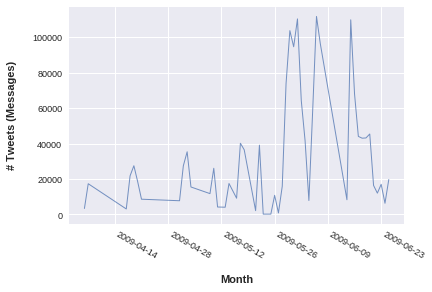

In [0]:
daily_plot = daily_count['Number_of_tweets'].plot(kind='line', lw=1, alpha=0.75, legend=True, x_compat=True)

daily_plot.set_xlabel('Month', weight='bold', labelpad=15)    #SET X-AXIS LABEL; ADD PADDING TO TOP OF LABEL
daily_plot.set_ylabel('# Tweets (Messages)', weight='bold', labelpad=15) #SET Y-AXIS LABEL; ADD PADDING TO RIGHT OF LABEL

xticks(fontsize = 9, rotation = -30, ha ="left")  #SET FONT PROPERTIES OF X-AXIS TICK LABELS
yticks(fontsize = 9)                              #SET FONT PROPERTIES OF Y-AXIS TICK LABELS

#http://matplotlib.org/users/legend_guide.html
#http://nbviewer.ipython.org/gist/olgabot/5357268  ### LIST OF OPTIONS
#legend(fontsize='x-small',loc=2,labelspacing=0.1, frameon=False)#.draggable()
daily_plot.legend_ = None
daily_plot.tick_params(axis='x', pad=5) #SET PADDING ABOVE X-AXIS LABELS
#Set x axis label on top of plot, set label text --> https://datasciencelab.wordpress.com/2013/12/21/beautiful-plots-with-pandas-and-matplotlib/
#daily_plot.xaxis.set_label_position('top')

savefig('daily counts.png', bbox_inches='tight', dpi=300, format='png') 

#Plot Day-of-the-Week Tweets

In [0]:
weekday_count = pdf.groupby(pdf.index.weekday).apply(f)
print len(weekday_count)
weekday_count

7


,Number_of_tweets
created_at,
0,310205
1,185850
2,96806
3,106035
4,225594
5,330955
6,344555


In [0]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_count['day'] = days
weekday_count

,Number_of_tweets,day
created_at,,
0,310205,Monday
1,185850,Tuesday
2,96806,Wednesday
3,106035,Thursday
4,225594,Friday
5,330955,Saturday
6,344555,Sunday


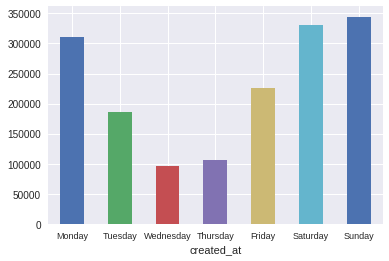

In [0]:
day_of_week_plot = weekday_count['Number_of_tweets'].plot(kind='bar')
xticks(np.arange(7), weekday_count['day'], rotation = 0, fontsize = 9) #, ha ="left") 

###IF WE DON'T WANT TO CREATE ANOTHER COLUMN IN DATAFRAME WE CAN SET CUSTOM LABELS
#days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
#xticks(np.arange(7), days, rotation = 0,fontsize = 9) #, ha ="left") 

savefig('day-of-week counts.png', bbox_inches='tight', dpi=300, format='png')

In [0]:
hourly_count = pdf.groupby(pdf.index.hour).apply(f)
print len(hourly_count)
hourly_count

24


,Number_of_tweets
created_at,
0,80865
1,75268
2,73991
3,74253
4,76995
5,78623
6,80852
7,83654
8,76287


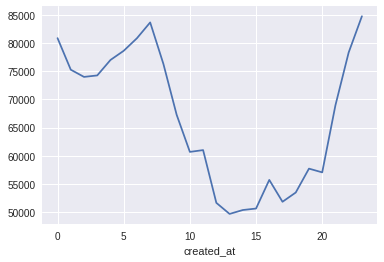

In [0]:
hourly_plot = hourly_count['Number_of_tweets'].plot()

([<matplotlib.axis.XTick at 0x7f29b9d139d0>,
 <a list of 24 Text xticklabel objects>)

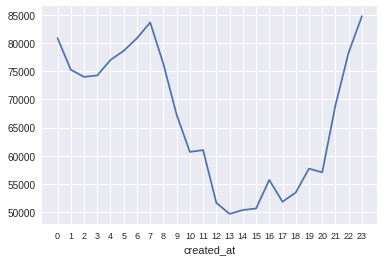

In [0]:
hourly_plot = hourly_count['Number_of_tweets'].plot()
xticks(np.arange(24), rotation = 0,fontsize = 9) #, ha ="left") 

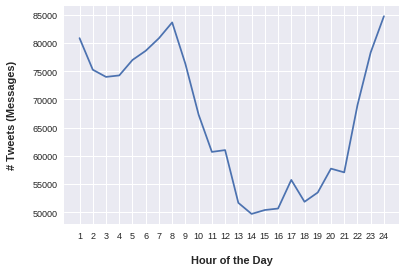

In [0]:
hourly_plot = hourly_count['Number_of_tweets'].plot(kind='line')
hours = list(range(1,25))                                                #GENERATE LIST FROM 1 TO 24
xticks(np.arange(24), hours, rotation = 0,fontsize = 9)                  #USE THE CUSTOM TICKS

hourly_plot.set_xlabel('Hour of the Day', weight='bold', labelpad=15)     #SET X-AXIS LABEL, ADD PADDING TO TOP OF X-AXIS LABEL
hourly_plot.set_ylabel('# Tweets (Messages)', weight='bold', labelpad=15) #SET Y-AXIS LABEL, ADD PADDING TO RIGHT OF Y-AXIS LABEL

xticks(fontsize = 9, rotation = 0, ha= "center")                          #SET FONT SIZE FOR X-AXIS TICK LABELS
yticks(fontsize = 9)                                                      #SET FONT SIZE FOR Y-AXIS TICK LABELS
daily_plot.tick_params(axis='x', pad=5)                                   #SET PADDING ABOVE X-AXIS LABELS

daily_plot.legend_ = None                                                 #TURN OFF LEGEND

savefig('hourly counts - line graph.png', bbox_inches='tight', dpi=300, format='png')

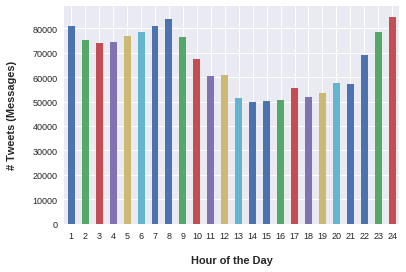

In [0]:
hourly_plot = hourly_count['Number_of_tweets'].plot(kind='bar')
hours = list(range(1,25))                                                 #GENERATE LIST FROM 1 TO 24
xticks(np.arange(24), hours, rotation = 0,fontsize = 9)                   #USE THE CUSTOM TICKS

hourly_plot.set_xlabel('Hour of the Day', weight='bold', labelpad=15)     #SET X-AXIS LABEL, ADD PADDING TO TOP OF X-AXIS LABEL
hourly_plot.set_ylabel('# Tweets (Messages)', weight='bold', labelpad=15) #SET Y-AXIS LABEL, ADD PADDING TO RIGHT OF Y-AXIS LABEL

xticks(fontsize = 9, rotation = 0, ha= "center")                          #SET FONT SIZE FOR X-AXIS TICK LABELS
yticks(fontsize = 9)                                                      #SET FONT SIZE FOR Y-AXIS TICK LABELS
daily_plot.tick_params(axis='x', pad=5)                                   #SET PADDING ABOVE X-AXIS LABELS

daily_plot.legend_ = None                                                 #TURN OFF LEGEND

savefig('hourly counts - bar graph.png', bbox_inches='tight', dpi=300, format='png')

In [0]:
monthly_count = pdf.groupby(pdf.index.month).apply(f)
print len(monthly_count)
monthly_count

3


,Number_of_tweets
created_at,
4,100025
5,576367
6,923608


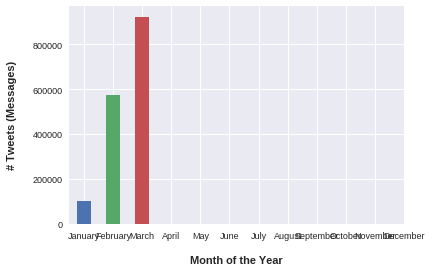

In [0]:
monthly_plot = monthly_count['Number_of_tweets'].plot(kind='bar')
months = list(calendar.month_name[1:])                                    #GENERATE LIST OF MONTHS
xticks(np.arange(12), months, rotation = 0,fontsize = 9)                  #USE THE CUSTOM TICKS

monthly_plot.set_xlabel('Month of the Year', weight='bold', labelpad=15)  #SET X-AXIS LABEL, ADD PADDING TO TOP OF X-AXIS LABEL
monthly_plot.set_ylabel('# Tweets (Messages)', weight='bold', labelpad=15) #SET Y-AXIS LABEL, ADD PADDING TO RIGHT OF Y-AXIS LABEL

xticks(fontsize = 9, rotation = 0, ha= "center")                          #SET FONT SIZE FOR X-AXIS TICK LABELS
yticks(fontsize = 9)                                                      #SET FONT SIZE FOR Y-AXIS TICK LABELS
daily_plot.tick_params(axis='x', pad=5)                                   #SET PADDING ABOVE X-AXIS LABELS

daily_plot.legend_ = None                                                 #TURN OFF LEGEND

savefig('monthly counts - bar graph.png', bbox_inches='tight', dpi=300, format='png')

In [0]:
minute_count = pdf.groupby(pdf.index.minute).apply(f)
print len(minute_count)
minute_count.head()

60


,Number_of_tweets
created_at,
0,26885
1,27422
2,26796
3,26698
4,26763


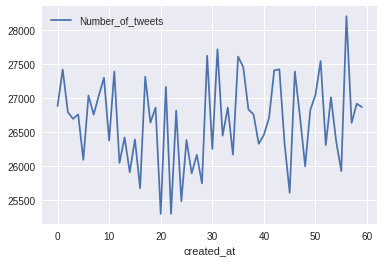

In [0]:
minute_count.plot()

In [0]:
second_count = pdf.groupby(pdf.index.second).apply(f)
print len(second_count)
second_count.head()

60


,Number_of_tweets
created_at,
0,25615
1,25210
2,26012
3,26775
4,27132


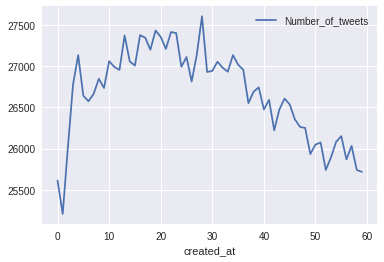

In [0]:
second_count.plot()

In [0]:
pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = (2000, 5)
pdf.head(10)

,_c0,_c1,_c2,_c3,_c4,_c5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
6,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
9,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?


In [0]:
hashtag_list = []                          #CREATE EMPTY LIST 
for i in pdf._c5:    #LOOP OVER EVERY CELL IN _c5
    if pd.notnull(i):                      #IF CELL NOT EMPTY
        tags = i.split()                   #SPLIT EACH CELL INTO SEPARATE HASHTAGS
        for t in tags:                     #FOR EACH TAG IN THE CELL
            t = "#"+t                      #ADD '#' SYMBOL TO BEGINNING OF EACH TAG
            t = t.replace(',', '')         #REMOVE COMMAS FROM END OF TAGS
            t = t.lower()                  #MAKE TAG LOWER CASE
            hashtag_list.append(t)         #ADD TAG TO OUR LIST
print len(hashtag_list)                    #PRINT NUMBER OF ITEMS IN OUR LIST
hashtag_list[:20]     

21080806


[u'#@switchfoot',
 u'#http://twitpic.com/2y1zl',
 u'#-',
 u'#awww',
 u"#that's",
 u'#a',
 u'#bummer.',
 u'#you',
 u'#shoulda',
 u'#got',
 u'#david',
 u'#carr',
 u'#of',
 u'#third',
 u'#day',
 u'#to',
 u'#do',
 u'#it.',
 u'#;d',
 u'#is']

In [0]:
hashtag_list_v2 = []     #CREATE EMPTY LIST 
for i in pdf._c5:           #LOOP OVER ITEMS IN 'S'
    hashtag = filter(lambda x: x.startswith('#'),i.split()) 
    hashtag = map(lambda x: x.strip('/;,-.:!?"''()'),hashtag)  ##remove the indicated punctuations
    hashtag = map(lambda x: x.strip(),hashtag)    #STRIP REMOVES 
    hashtag = map(lambda x: x.lower(),hashtag)    #IF WE WANT LOWER CASE TAGS (OTHERWISE, COUNT IS CASE SENSITIVE)
    hashtag_list_v2.extend(hashtag)  
print len(hashtag_list_v2)
hashtag_list_v2[:20]

44109


[u'#itm',
 u'#therapyfail',
 u'#fb',
 u'#ttsc',
 u'#24',
 u'#gayforpeavy',
 u'#fml',
 u'#3',
 u'#camerafail',
 u'#',
 u'#...we',
 u'#fb',
 u'#travian',
 u'#wow',
 u'#art',
 u'#fail',
 u'#krispykreme',
 u'#fb',
 u'#24',
 u'#the']

In [0]:
Series(hashtag_list).value_counts()

#i                            746870
#to                           560929
#the                          518779
#a                            376484
#my                           312992
#and                          296161
#you                          242762
#is                           232060
#for                          214205
#in                           210694
#it                           196591
#of                           182700
#on                           162542
#so                           147727
#have                         143484
#me                           133245
#that                         130716
#i'm                          127632
#but                          125857
#just                         124501
#with                         113631
#be                           110792
#at                           110415
#was                          102981
#not                          102830
#this                          88863
#get                           81003
#

In [0]:
cnt_hashtags = DataFrame(Series(hashtag_list).value_counts())  
cnt_hashtags.columns = ['tag_frequency']                       #GIVE A NAME TO THE COLUMN
print len(cnt_hashtags)
cnt_hashtags

1153408


,tag_frequency
#i,746870
#to,560929
#the,518779
#a,376484
#my,312992
#and,296161
#you,242762
#is,232060
#for,214205
#in,210694


In [0]:
def count_hashtags(s):
    hashtag_list_v3 = []     #CREATE EMPTY LIST 
    for i in s:           #LOOP OVER ITEMS IN 'S'
        hashtag = filter(lambda x: x.startswith('#'),i.split()) 
        hashtag = map(lambda x: x.strip('/;,-.:!?"''()'),hashtag)  ##remove the indicated punctuations
        hashtag = map(lambda x: x.strip(),hashtag)    #STRIP REMOVES 
        hashtag = map(lambda x: x.lower(),hashtag)    #IF WE WANT LOWER CASE TAGS (OTHERWISE, COUNT IS CASE SENSITIVE)
        hashtag_list_v3.extend(hashtag)  
    return DataFrame(Series(hashtag_list_v3).value_counts())

In [0]:
count_hashtags(pdf._c5)  #INVOKE FUNCTION AND PROVIDE NAME TO DATAFRAME

,0
#followfriday,2593
#fb,1770
#ff,958
#squarespace,929
#,545
#iranelection,508
#seb-day,499
#1,480
#musicmonday,413
#fail,362


In [0]:
#cnt_hashtags['tag_frequency'].plot()
cnt_hashtags_filtered = cnt_hashtags[(cnt_hashtags['tag_frequency'] >= 100)] #ignore less than 10
len(cnt_hashtags_filtered)


9969

In [0]:
import matplotlib
import matplotlib.pyplot as plt
from pylab import*
import seaborn as sns
plt.rcParams['figure.figsize'] = (15, 5)

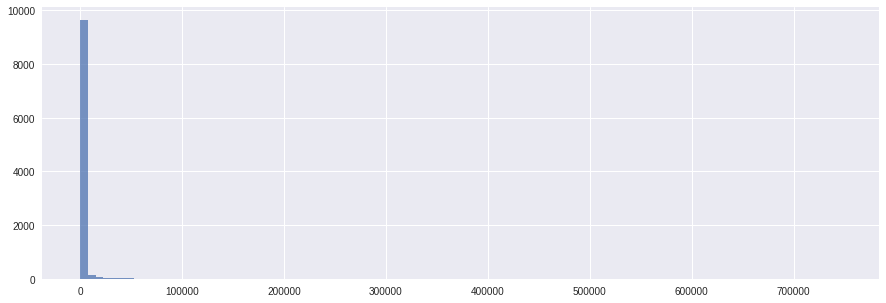

In [0]:
density_plot = cnt_hashtags_filtered['tag_frequency'].hist(bins=100, alpha=0.75)

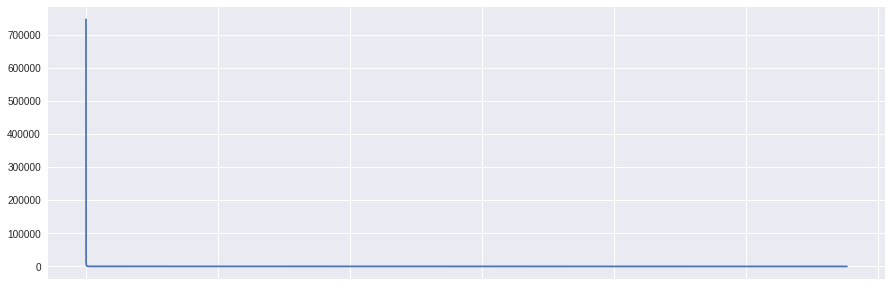

In [0]:
cnt_hashtags['tag_frequency'].plot()

In [0]:
cnt_hashtags['tag_frequency'].value_counts()

1         824031
2         130519
3          53561
4          29678
5          18938
6          13135
7           9666
8           7548
9           5994
10          4884
11          4067
12          3360
13          2953
14          2463
15          2263
16          1934
17          1774
18          1567
19          1441
20          1326
21          1185
22          1030
23          1001
24           942
25           833
26           813
27           728
28           696
29           616
31           573
           ...  
604            1
2653           1
3661           1
6735           1
5685           1
8776           1
1591           1
18993          1
1592           1
312992         1
6714           1
2618           1
6718           1
5692           1
1598           1
2622           1
38445          1
1600           1
3650           1
1603           1
14915          1
2628           1
1605           1
5700           1
1606           1
2632           1
14926          1
6729          

In [0]:
#cnt_hashtags['tag_frequency'].plot()
cnt_hashtags_single = cnt_hashtags[(cnt_hashtags['tag_frequency'] == 1)] #ignore less than 10
print len(cnt_hashtags_single)
print len(cnt_hashtags)


824031
1153408


In [0]:
from __future__ import division
len(cnt_hashtags_single)/len(cnt_hashtags) #percentage of single hashtags

NameError: ignored

In [0]:
cnt_hashtags['tag_frequency'].value_counts(normalize=True)

1         7.144315e-01
2         1.131594e-01
3         4.643717e-02
4         2.573070e-02
5         1.641917e-02
6         1.138799e-02
7         8.380382e-03
8         6.544085e-03
9         5.196773e-03
10        4.234408e-03
11        3.526072e-03
12        2.913106e-03
13        2.560239e-03
14        2.135411e-03
15        1.962012e-03
16        1.676770e-03
17        1.538051e-03
18        1.358583e-03
19        1.249341e-03
20        1.149637e-03
21        1.027390e-03
22        8.930058e-04
23        8.678629e-04
24        8.167101e-04
25        7.222076e-04
26        7.048677e-04
27        6.311730e-04
28        6.034291e-04
29        5.340695e-04
31        4.967886e-04
              ...     
604       8.669959e-07
2653      8.669959e-07
3661      8.669959e-07
6735      8.669959e-07
5685      8.669959e-07
8776      8.669959e-07
1591      8.669959e-07
18993     8.669959e-07
1592      8.669959e-07
312992    8.669959e-07
6714      8.669959e-07
2618      8.669959e-07
6718      8

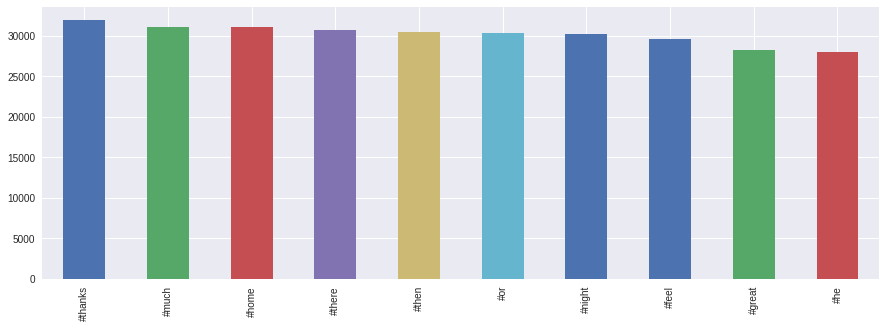

In [0]:
cnt_hashtags['tag_frequency'][90:100].plot(kind='bar')

In [0]:
cnt_hashtags['tag_frequency'][:25]

#i       746870
#to      560929
#the     518779
#a       376484
#my      312992
#and     296161
#you     242762
#is      232060
#for     214205
#in      210694
#it      196591
#of      182700
#on      162542
#so      147727
#have    143484
#me      133245
#that    130716
#i'm     127632
#but     125857
#just    124501
#with    113631
#be      110792
#at      110415
#was     102981
#not     102830
Name: tag_frequency, dtype: int64

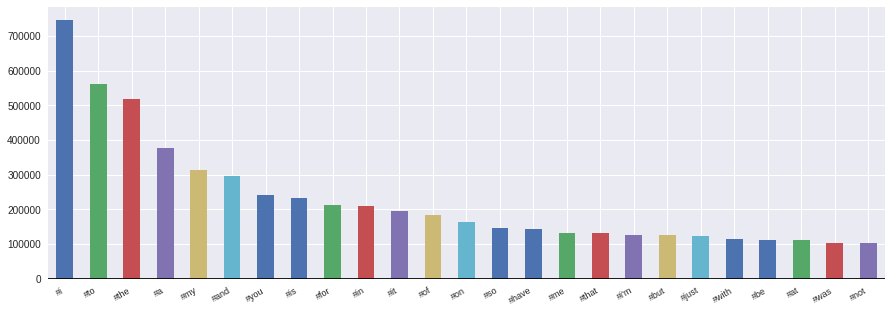

In [0]:
cnt_hashtags['tag_frequency'][:25].plot(kind='bar')
axhline(0, color='k')
#title('Top 25 hashtags')
xticks(fontsize = 9,rotation = 30, ha='right')
savefig('25 most popular tags.png', bbox_inches='tight', dpi=300, format='png')
show()

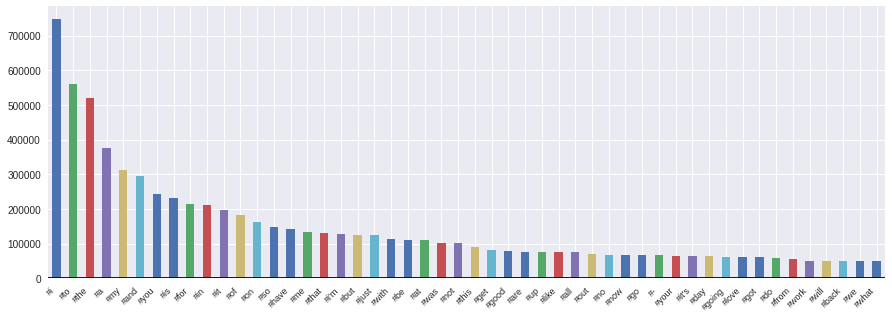

In [0]:
cnt_hashtags['tag_frequency'].head(50).plot(kind='bar')
axhline(0, color='k')
#title('Top 50 hashtags')
xticks(fontsize = 9,rotation = 45, ha='right')
savefig('50 most popular tags.png', bbox_inches='tight', dpi=300, format='png')
show()

In [0]:
all_tags = []
for index, row in pdf.iterrows():    
        if pd.notnull(row['_c5']):
            tags = row['_c5'].lower()
            #print tags
        else:
            tags = ''
            #print row['_c5'], " -- No hashtags in tweet"
        tags = tags.replace(',','')
        all_tags.append(tags) 
        
all_hashtags = ' '.join(all_tags)

In [0]:
print all_hashtags[:1000] 

@switchfoot http://twitpic.com/2y1zl - awww that's a bummer.  you shoulda got david carr of third day to do it. ;d is upset that he can't update his facebook by texting it... and might cry as a result  school today also. blah! @kenichan i dived many times for the ball. managed to save 50%  the rest go out of bounds my whole body feels itchy and like its on fire  @nationwideclass no it's not behaving at all. i'm mad. why am i here? because i can't see you all over there.  @kwesidei not the whole crew  need a hug  @loltrish hey  long time no see! yes.. rains a bit only a bit  lol  i'm fine thanks  how's you ? @tatiana_k nope they didn't have it  @twittera que me muera ?  spring break in plain city... it's snowing  i just re-pierced my ears  @caregiving i couldn't bear to watch it.  and i thought the ua loss was embarrassing . . . . . @octolinz16 it it counts idk why i did either. you never talk to me anymore  @smarrison i would've been the first but i didn't have a gun.    not really tho

In [0]:
from wordcloud import WordCloud

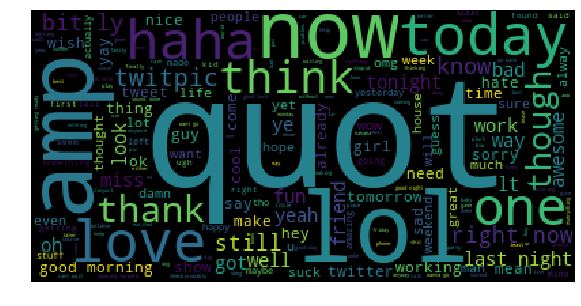

In [0]:
wordcloud = WordCloud().generate(all_hashtags)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [0]:
all_hashtags_filtered = all_hashtags[1:10000]
print type(all_hashtags)
print type(all_hashtags_filtered)

<type 'unicode'>
<type 'unicode'>


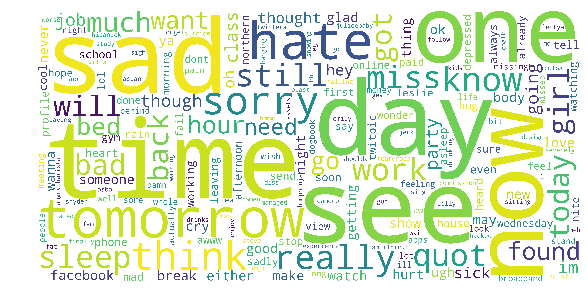

In [0]:
wordcloud = WordCloud(background_color='white',
                      width=5600,
                      height=2800
                     ).generate(all_hashtags_filtered)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [0]:
from IPython.display import Image
Image(width=800, filename='CSR tag cloud - wordle.png') 

In [0]:
from IPython.display import Image
Image(width=800, filename='CSR tag cloud (wordle - Kenyan Coffee).png') 

## CountVectorizer + IDF + Logistic Regression

There's another way that you can get term frequecy for IDF (Inverse Document Freqeuncy) calculation. It is CountVectorizer in SparkML. Apart from the reversibility of the features (vocabularies), there is an important difference in how each of them filters top features. In case of HashingTF it is dimensionality reduction with possible collisions. CountVectorizer discards infrequent tokens.

Let's see if performance changes if we use Countvectorizer instead of HashingTF.

In [0]:
%%time
from pyspark.ml.feature import CountVectorizer

tokenizer = Tokenizer(inputCol=text, outputCol="words")
cv = CountVectorizer(vocabSize=2**16, inputCol="words", outputCol='cv')
idf = IDF(inputCol='cv', outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms
label_stringIdx = StringIndexer(inputCol = target, outputCol = "label")
lr = LogisticRegression(maxIter=100)
pipeline = Pipeline(stages=[tokenizer, cv, idf, label_stringIdx, lr])

pipelineFit = pipeline.fit(train_set)
predictions = pipelineFit.transform(val_set)
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(val_set.count())
roc_auc = evaluator.evaluate(predictions)

print "Accuracy Score: {0:.4f}".format(accuracy)
print "ROC-AUC: {0:.4f}".format(roc_auc)

It looks like using CountVectorizer has improved the performance a little bit.

## N-gram Implementation

In Scikit-Learn, n-gram implementation is fairly easy. You can define range of n-grams when you call TfIdf Vectorizer. But with Spark, it is a bit more complicated. It does not automatically combine features from different n-grams, so I had to use VectorAssembler in the pipeline, to combine the features I get from each n-grams.

I first tried to extract around 16,000 features from unigram, bigram, trigram. This means I will get around 48,000 features in total. Then I implemented Chi Squared feature selection to reduce the features back to 16,000 in total.

In [0]:
from pyspark.ml.feature import NGram, VectorAssembler
from pyspark.ml.feature import ChiSqSelector

def build_trigrams(inputCol=[text,target], n=3):
    tokenizer = [Tokenizer(inputCol=text, outputCol="words")]
    ngrams = [
        NGram(n=i, inputCol="words", outputCol="{0}_grams".format(i))
        for i in range(1, n + 1)
    ]

    cv = [
        CountVectorizer(vocabSize=2**14,inputCol="{0}_grams".format(i),
            outputCol="{0}_tf".format(i))
        for i in range(1, n + 1)
    ]
    idf = [IDF(inputCol="{0}_tf".format(i), outputCol="{0}_tfidf".format(i), minDocFreq=5) for i in range(1, n + 1)]

    assembler = [VectorAssembler(
        inputCols=["{0}_tfidf".format(i) for i in range(1, n + 1)],
        outputCol="rawFeatures"
    )]
    label_stringIdx = [StringIndexer(inputCol = target, outputCol = "label")]
    selector = [ChiSqSelector(numTopFeatures=2**14,featuresCol='rawFeatures', outputCol="features")]
    lr = [LogisticRegression(maxIter=100)]
    return Pipeline(stages=tokenizer + ngrams + cv + idf+ assembler + label_stringIdx+selector+lr)

In [0]:
%%time
trigram_pipelineFit = build_trigrams().fit(train_set)
predictions = trigram_pipelineFit.transform(val_set)
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(dev_set.count())
roc_auc = evaluator.evaluate(predictions)

# print accuracy, roc_auc
print "Accuracy Score: {0:.4f}".format(accuracy)
print "ROC-AUC: {0:.4f}".format(roc_auc)

Accuracy has improved, but as you might have noticed, fitting the model took 4 hours! And this is mainly because of ChiSqSelector.

What if I extract 5,460 features each from unigram, bigram, trigram in the first place, to have around 16,000 features in total in the end, without Chi Squared feature selection?

In [0]:
from pyspark.ml.feature import NGram, VectorAssembler

def build_ngrams_wocs(inputCol=[text,target], n=3):
    tokenizer = [Tokenizer(inputCol=target, outputCol="words")]
    ngrams = [
        NGram(n=i, inputCol="words", outputCol="{0}_grams".format(i))
        for i in range(1, n + 1)
    ]

    cv = [
        CountVectorizer(vocabSize=5460,inputCol="{0}_grams".format(i),
            outputCol="{0}_tf".format(i))
        for i in range(1, n + 1)
    ]
    idf = [IDF(inputCol="{0}_tf".format(i), outputCol="{0}_tfidf".format(i), minDocFreq=5) for i in range(1, n + 1)]

    assembler = [VectorAssembler(
        inputCols=["{0}_tfidf".format(i) for i in range(1, n + 1)],
        outputCol="features"
    )]
    label_stringIdx = [StringIndexer(inputCol = target, outputCol = "label")]
    lr = [LogisticRegression(maxIter=100)]
    return Pipeline(stages=tokenizer + ngrams + cv + idf+ assembler + label_stringIdx+lr)

In [0]:
%%time

trigramwocs_pipelineFit = build_ngrams_wocs().fit(train_set)
predictions_wocs = trigramwocs_pipelineFit.transform(val_set)
accuracy_wocs = predictions_wocs.filter(predictions_wocs.label == predictions_wocs.prediction).count() / float(val_set.count())
roc_auc_wocs = evaluator.evaluate(predictions_wocs)

# print accuracy, roc_auc
print "Accuracy Score: {0:.4f}".format(accuracy_wocs)
print "ROC-AUC: {0:.4f}".format(roc_auc_wocs)

This has given me almost same result, marginally lower, but the difference is in the fourth digit. Considering it takes only 8 mins without ChiSqSelector, I choose the model without ChiSqSelector.

And finally, let's try this model on the final test set.

In [0]:
test_predictions = trigramwocs_pipelineFit.transform(test_set)
test_accuracy = test_predictions.filter(test_predictions.label == test_predictions.prediction).count() / float(test_set.count())
test_roc_auc = evaluator.evaluate(test_predictions)

# print accuracy, roc_auc
print "Accuracy Score: {0:.4f}".format(test_accuracy)
print "ROC-AUC: {0:.4f}".format(test_roc_auc)

Final test accuracy is 81.22%.